In [4]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
import warnings
import numpy as np
import gym
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [18]:
def plot_rewards(rewards, round):
    plt.plot(range(0,round + 1), rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Mean Reward")
    plt.title("Mean Reward per Episode")
    plt.show()

Round -1 :Initial mean reward -42.30633200638368 --- Initial top 20 reward is 56.54612297857976
Start training...
Press any key to continue. Please record the final episode jkjk

Start testing
Final mean reward -15177.622575747579


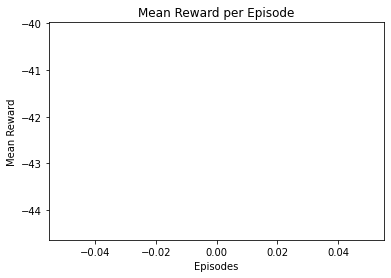

In [29]:
def nn_train(gpu = False, size_hidden_layer = 100, learningrate=1e-4, momentum = 0.5, mean_reward_threshold = 100, EPISODEN = 100,  STEPS_PER_EPISODE = 500):

    env = gym.make('LunarLander-v2')
    env.seed(random_seed)

    class Net(nn.Module):
        def __init__(self, D_in, H, D_out):
            super(Net, self).__init__()
            self.linear1 = nn.Linear(D_in, H)
            self.relu1 = torch.nn.ReLU()
            self.linear2 = nn.Linear(H, D_out)

        def forward(self, x):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            l1 = self.linear1(x) 
            h_relu = self.relu1(l1)
            #y_pred = nn.Softmax(self.linear2(h_relu))
            y_pred = self.linear2(h_relu)
            # y_pred = self.soft_max(self.linear2(h_relu))
            return y_pred

    def train(episodes_data):
        model.train()

        for episode in episodes_data:
            for data, target in episode:
                data = torch.tensor(data, device = device)
                target = torch.tensor(target, device = device)
                optimizer.zero_grad()
                y_pred = model(data)
                y_pred = torch.unsqueeze(y_pred, 0)
                target = torch.unsqueeze(target, 0)
                #y_pred = torch.Tensor(y_pred, device="cpu")
                #y_pred = int(np.argmax(y_pred.cpu().detach().numpy()))
                # print(y_pred.shape)
                loss = criterion(y_pred, target)
                loss.backward()
                optimizer.step()
            # print(f"Loss for most recent episode is {loss.item()}")

    #diese methode kann zum erstellen von trainingdaten als auch für das 
    #testen des aktuellen modells verwendet werden
    def generate_train_data(episoden, rendering):
        model.eval()
        all_scores = []
        episodes = [] # [ [(state, action), (),...()], [(state, action), (),...()], ...]
        rewards = []
        sm = nn.Softmax(dim=0)
        for i in range(episoden):
            obs = env.reset() # reset for each new trial  
            state_action_pairs_per_episode = [] #[(state, action),(), ...]
            episode_reward = 0

            for t in range(STEPS_PER_EPISODE): # run for maximum 500 timesteps or until done, whichever is first
                #get states and put into network
                
                with torch.no_grad():
                    data = torch.tensor(obs, device = device)
                    outputs = model(data)
#                     print(outputs)
                    propability_dist = sm(outputs).cpu().detach().numpy()
#                     print(propability_dist)
                    outputs = outputs.cpu().detach().numpy()
                    choice = np.random.choice(outputs, size=1, p=propability_dist)

                    new_action = np.where((outputs == choice))[0][0] # new approach
#                 new_action = int(np.argmax(outputs.cpu())) #old approach
                state_action_tupel = (obs, new_action)
                state_action_pairs_per_episode.append(state_action_tupel)
        
                if rendering:
                    env.render()
                obs, reward, done, info = env.step(new_action)
                episode_reward+=reward

                if done and (not rendering):
                  #print("Episode finished after {} timesteps".format(t+1))
                    break

                #print(episode_reward/STEPS_PER_EPISODE)
                episodes.append(state_action_pairs_per_episode)
                rewards.append(episode_reward)
            env.close()


        rewards = np.array(rewards)
        episodes = np.array(episodes)
        sort_index = rewards.argsort()
        top_rewards = rewards[sort_index[::-1]][:20]
        top_episodes = episodes[sort_index[::-1]][:20]
        return top_episodes, top_rewards.mean(), rewards.mean()

    D_in = 8
    H = size_hidden_layer
    D_out = 4
    all_rewards = 0
    round = 0 
    rewards = []
    
    model = Net(D_in, H, D_out)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learningrate, momentum=momentum)
    if gpu: 
        model.cuda()

    """ Get initial training episodes  """
    train_data, top_rewards, all_rewards = generate_train_data(EPISODEN, rendering = False)
    print("Round -1 :Initial mean reward {} --- Initial top 20 reward is {}".format(all_rewards, top_rewards, round))
    print("Start training...")
    rewards.append(all_rewards)

    """ Traing until mean reward hits threshold  """
    while (all_rewards < mean_reward_threshold):
        train(train_data)
        train_data, top_rewards, all_rewards = generate_train_data(EPISODEN, rendering = False)
        print("Round {}: Current mean reward {} --- Top 20 reward is {}".format(round, all_rewards, top_rewards))
        rewards.append(all_rewards)
        round = round + 1
    
    """ test with one final rendered epsiode  """
    waiting_mechanism = input("Press any key to continue. Please record the final episode ")
    print("\nStart testing")

    train_data, top_rewards, all_rewards = generate_train_data(1, rendering = True)
    print("Final mean reward {}".format(all_rewards, top_rewards, round))
    
    plot_rewards(rewards, round)
        
nn_train(gpu = True, 
         size_hidden_layer = 500, 
         learningrate=0.1, 
         momentum = 0.3, 
         mean_reward_threshold = -45, 
         EPISODEN = 100,  
         STEPS_PER_EPISODE = 500)

In [25]:
import gym
env = gym.make('LunarLander-v2')
env.reset()
for _ in range(1000):
    env.render()
    obs, reward, done, info = env.step(env.action_space.sample()) # take a random action
#     if done:
#         break
env.close()